# Transmit and Receive Sensor Selection Using the Multiplicity in the Virtual Array

## Paper Abstract

> The main focus of this paper is an active sensing application that involves selecting transmit and receive sensors to optimize the Cramér-Rao bound (CRB) on target parameters. Although the CRB is non-convex in the transmit and receive selection, we demonstrate that it is convex in the virtual array weight vector, which describes the multiplicity of the virtual array elements. Based on this finding, we propose a novel algorithm that optimizes the virtual array weight vector first and then finds a matching transceiver array. This greatly enhances the efficiency of the transmit and receive sensor selection problem.

## Preamble

In [1]:
import numpy as np
from functions import *
from using_multiplicity import *
from solveDirectly import *
import plot
from tqdm.contrib.itertools import product
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import statistics

# Seaborn Set-up
sns.set_theme(style="darkgrid")

figsize = plot.style("ieee-conf")

np.set_printoptions(precision=2)


Bad value in file '/home/costasak/projects/tudelft/eusipco2024/ieee-conf.mplstyle', line 22 ('savefig.pad_inches: layout'): Key savefig.pad_inches: Could not convert 'layout' to float


## Multiplicity Example

In [2]:
p_tx = np.array([1, 0, 1])
p_rx = np.array([1, 0, 1, 0, 1, 1])

tx_indices = np.squeeze(np.nonzero(p_tx))
tx_blank_indices = np.squeeze(np.nonzero(1 - p_tx))
rx_indices = np.squeeze(np.nonzero(p_rx))
rx_blank_indices = np.squeeze(np.nonzero(1 - p_rx))

multiplicity_example = np.convolve(p_tx, p_rx)
mult_indices = np.squeeze(np.nonzero(multiplicity_example))
mult_blank_indices = np.squeeze(np.where(multiplicity_example == 0))
sum_array_length = len(multiplicity_example)

number_of_tx = np.sum(p_tx)
number_of_rx = np.sum(p_rx)

maximum_multiplicity = min(number_of_tx, number_of_rx)


### Fig. 2a

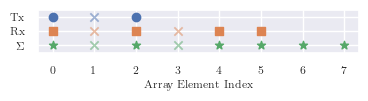

In [3]:
_, axs = plt.subplots(1, 1, figsize=figsize * [1, 0.35])

x = np.arange(sum_array_length)

axs.scatter(tx_indices, np.ones(number_of_tx) * 2, marker="o", color="C0")
axs.scatter(
    tx_blank_indices,
    np.ones(len(p_tx) - number_of_tx) * 2,
    marker="x",
    color="C0",
    alpha=0.5,
)
axs.scatter(rx_indices, np.ones(number_of_rx), marker="s", color="C1")
axs.scatter(
    rx_blank_indices,
    np.ones(len(p_rx) - number_of_rx),
    marker="x",
    color="C1",
    alpha=0.5,
)
axs.scatter(mult_indices, np.zeros(len(mult_indices)), marker="*", color="C2")
axs.scatter(
    mult_blank_indices,
    np.zeros(sum_array_length - len(mult_indices)),
    marker="x",
    color="C2",
    alpha=0.5,
)
axs.set_xticks(range(sum_array_length))
axs.set_xlabel("Array Element Index")
axs.set_ylim([-0.5, 2.5])
axs.set_yticks([0, 1, 2], ["$\Sigma$", "Rx", "Tx"])

plot.savefig("figures/sum_array_example.pdf")


### Fig. 2b

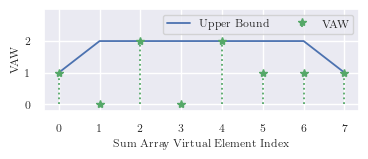

In [4]:
_, axs = plt.subplots(1, 1, figsize=figsize * np.array([1, 0.6]))

axs.plot(
    x,
    np.concatenate(
        [
            np.arange(1, maximum_multiplicity),
            maximum_multiplicity
            * np.ones(sum_array_length + 2 - 2 * maximum_multiplicity),
            np.flip(np.arange(1, maximum_multiplicity)),
        ]
    ),
    "C0-",
    label="Upper Bound",
)
axs.stem(
    x,
    multiplicity_example,
    linefmt="C2:",
    markerfmt="*",
    basefmt=" ",
    label="VAW",
)
axs.set_xticks(range(sum_array_length))
axs.set_xlabel("Sum Array Virtual Element Index")
axs.set_ylim([-0.2, 3])
axs.set_yticks(range(maximum_multiplicity + 1))
axs.set_ylabel("VAW")
axs.legend(ncol=2)

plot.savefig("figures/multiplicity_example.pdf")

## Monte Carlo Simulations


### CRB Histogram Example

#### Load / Generate Dataframe

In [5]:
number_of_trials = 100
number_of_targets_list = [28]
number_of_positions_list = [32]

angle_noise_std = 0

element_spacing = 0.5

dataframe_name = "histogram"
target_angles = []

try:
    monte_carlo_results_df = pd.read_pickle("dataframes/" + dataframe_name + ".xz")
except:
    monte_carlo_results_list = []
    for number_of_positions, number_of_targets, trial in product(
        number_of_positions_list, number_of_targets_list, range(number_of_trials)
    ):
        number_of_transmit_positions = number_of_positions
        number_of_receive_positions = number_of_positions
        number_of_transmitters = int(np.floor(number_of_positions / 2))
        number_of_receivers = int(np.ceil(number_of_positions / 2))

        target_angles = uniform_target_angles(
            number_of_targets,
            aperture=number_of_transmit_positions + number_of_receive_positions - 1,
            noise_std=angle_noise_std,
        )

        sum_array_response = generateSumArrayResponse(
            target_angles,
            number_of_transmit_positions,
            number_of_receive_positions,
            element_spacing,
        )

        initialization = {
            "tx": randomized_rounding(
                np.ones(number_of_transmit_positions), number_of_transmitters
            ),
            "rx": randomized_rounding(
                np.ones(number_of_receive_positions), number_of_receivers
            ),
        }

        tx, rx, stats = solveTxRxDirectly(
            sum_array_response,
            number_of_transmitters,
            number_of_receivers,
            number_of_transmit_positions,
            number_of_receive_positions,
            roundIntermediates=False,
            initialization=initialization,
        )

        monte_carlo_results_list.append(
            {
                "Method": "Alg. 1",
                "Tx": tx,
                "Rx": rx,
                "Target Angles": target_angles,
                "Number of Transmit Positions": number_of_transmit_positions,
                "Number of Receive Positions": number_of_receive_positions,
                "Number of Transmitters": number_of_transmitters,
                "Number of Receivers": number_of_receivers,
                "Element Spacing": element_spacing,
                "Initialization": initialization,
                "Stats": stats,
            }
        )

        tx, rx, stats = solve_tx_and_rx_using_multiplicity(
            sum_array_response,
            number_of_transmitters,
            number_of_receivers,
            number_of_transmit_positions,
            number_of_receive_positions,
            weighted=False,
            round_intermediates=False,
            initialization=initialization,
        )

        monte_carlo_results_list.append(
            {
                "Method": "Alg. 2",
                "Weighted": "No",
                "Tx": tx,
                "Rx": rx,
                "Target Angles": target_angles,
                "Number of Transmit Positions": number_of_transmit_positions,
                "Number of Receive Positions": number_of_receive_positions,
                "Number of Transmitters": number_of_transmitters,
                "Number of Receivers": number_of_receivers,
                "Element Spacing": element_spacing,
                "Initialization": initialization,
                "Stats": stats,
            }
        )

    monte_carlo_results_df = pd.DataFrame(monte_carlo_results_list)
    monte_carlo_results_df.to_pickle("dataframes/" + dataframe_name + ".xz", compression="xz")

#### Calculate CRB

In [6]:
monte_carlo_results_df["Worst CRB"] = monte_carlo_results_df.apply(worst_crb_df, axis=1)

#### Fig. 3

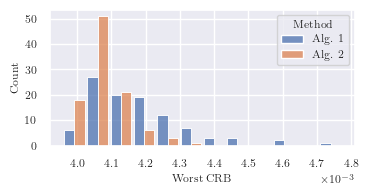

In [7]:
_, axs = plt.subplots(1, 1, figsize=figsize * np.array([1, 0.75]))

sns.histplot(
    data=monte_carlo_results_df,
    x="Worst CRB",
    bins=12,
    hue="Method",
    multiple="dodge",
    shrink=0.875,
    ax=axs,
)

axs.ticklabel_format(scilimits=[-1, 3])

plot.savefig("figures/histplot_targets.pdf")

### Solve Time Plots

In [8]:
number_of_trials = 20
number_of_targets_list = np.round(np.linspace(63, 8, 20, endpoint=True)).astype("int")
number_of_positions_list = [32]

angle_noise_std = 0

element_spacing = 0.5

dataframe_name = "solvetime"
target_angles = []

try:
    monte_carlo_results_df = pd.read_pickle("dataframes/" + dataframe_name + ".xz")
except:
    monte_carlo_results_list = []
    for number_of_positions, number_of_targets, trial in product(
        number_of_positions_list, number_of_targets_list, range(number_of_trials)
    ):
        number_of_transmit_positions = number_of_positions
        number_of_receive_positions = number_of_positions
        number_of_transmitters = int(np.floor(number_of_positions / 2))
        number_of_receivers = int(np.ceil(number_of_positions / 2))

        target_angles = uniform_target_angles(
            number_of_targets,
            aperture=number_of_transmit_positions + number_of_receive_positions - 1,
            noise_std=angle_noise_std,
        )

        sum_array_response = generateSumArrayResponse(
            target_angles,
            number_of_transmit_positions,
            number_of_receive_positions,
            element_spacing,
        )

        initialization = {
            "tx": randomized_rounding(
                np.ones(number_of_transmit_positions), number_of_transmitters
            ),
            "rx": randomized_rounding(
                np.ones(number_of_receive_positions), number_of_receivers
            ),
        }

        tx, rx, stats = solveTxRxDirectly(
            sum_array_response,
            number_of_transmitters,
            number_of_receivers,
            number_of_transmit_positions,
            number_of_receive_positions,
            roundIntermediates=False,
            initialization=initialization,
        )

        monte_carlo_results_list.append(
            {
                "Method": "Alg. 1",
                "Tx": tx,
                "Rx": rx,
                "Target Angles": target_angles,
                "Number of Transmit Positions": number_of_transmit_positions,
                "Number of Receive Positions": number_of_receive_positions,
                "Number of Transmitters": number_of_transmitters,
                "Number of Receivers": number_of_receivers,
                "Element Spacing": element_spacing,
                "Initialization": initialization,
                "Stats": stats,
            }
        )

        tx, rx, stats = solve_tx_and_rx_using_multiplicity(
            sum_array_response,
            number_of_transmitters,
            number_of_receivers,
            number_of_transmit_positions,
            number_of_receive_positions,
            weighted=False,
            round_intermediates=False,
            initialization=initialization,
        )

        monte_carlo_results_list.append(
            {
                "Method": "Alg. 2",
                "Weighted": "No",
                "Tx": tx,
                "Rx": rx,
                "Target Angles": target_angles,
                "Number of Transmit Positions": number_of_transmit_positions,
                "Number of Receive Positions": number_of_receive_positions,
                "Number of Transmitters": number_of_transmitters,
                "Number of Receivers": number_of_receivers,
                "Element Spacing": element_spacing,
                "Initialization": initialization,
                "Stats": stats,
            }
        )

    monte_carlo_results_df = pd.DataFrame(monte_carlo_results_list)
    monte_carlo_results_df.to_pickle("dataframes/" + dataframe_name + ".xz", compression="xz")

#### Calculate Solve Time

In [9]:
monte_carlo_results_df["Number of Targets"] = monte_carlo_results_df[
    "Target Angles"
].apply(lambda x: len(x))

monte_carlo_results_df["Solve Time"] = monte_carlo_results_df["Stats"].apply(
    lambda x: x["total"]["solveTime"]
)

monte_carlo_results_df["Iterations of Alternating Optimization"] = (
    monte_carlo_results_df["Stats"].apply(
        lambda x: x["total"]["alternatingDescentIterations"]
    )
)

monte_carlo_results_df["Average Time per Iteration"] = monte_carlo_results_df[
    "Stats"
].apply(
    lambda stats: statistics.fmean(
        [
            (
                x["txStats"]["solverStats"].solve_time
                + x["rxStats"]["solverStats"].solve_time
            )
            / 2
            for x in stats["alternatingDescent"]
        ]
    )
)

#### Fig. 4a

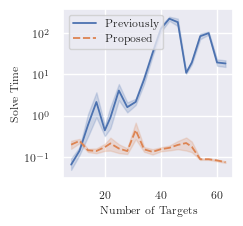

In [10]:
_, axs = plt.subplots(1, 1, figsize=figsize * np.array([0.64, 0.89]))

sns.lineplot(
    data=monte_carlo_results_df,
    x="Number of Targets",
    y="Solve Time",
    hue="Method",
    style="Method",
    ax=axs,
)

axs.set_yscale("log")

h, _ = axs.get_legend_handles_labels()
axs.legend(h, ["Previously", "Proposed"])

plot.savefig("figures/solvetime_vs_number_of_targets.pdf")

#### Fig. 4b

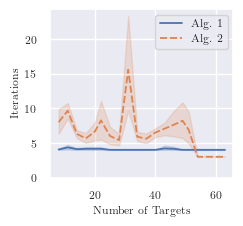

In [11]:
_, axs = plt.subplots(1, 1, figsize=figsize * np.array([0.64, 0.89]))

sns.lineplot(
    data=monte_carlo_results_df,
    x="Number of Targets",
    y="Iterations of Alternating Optimization",
    hue="Method",
    style="Method",
    ax=axs,
)
axs.set_ylim(bottom=0)
axs.set_ylabel("Iterations")

h, _ = axs.get_legend_handles_labels()
axs.legend(h, ["Alg. 1", "Alg. 2"])

plot.savefig("figures/iterations_vs_number_of_targets.pdf")

#### Solve Time Per Iteration

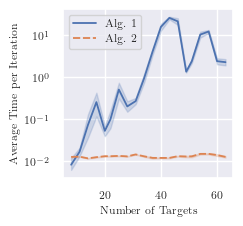

In [12]:
_, axs = plt.subplots(1, 1, figsize=figsize * np.array([0.64, 0.89]))

sns.lineplot(
    data=monte_carlo_results_df,
    x="Number of Targets",
    y="Average Time per Iteration",
    hue="Method",
    style="Method",
    ax=axs,
)
axs.set_yscale("log")

h, _ = axs.get_legend_handles_labels()
axs.legend(h, ["Alg. 1", "Alg. 2"])

plot.savefig("figures/average_time_per_iteration_vs_number_of_targets.pdf")